In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Считать данные в pandas dataframe
data = pd.read_csv('ex1data1.csv')
data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


Text(0.5, 1.0, 'dependency')

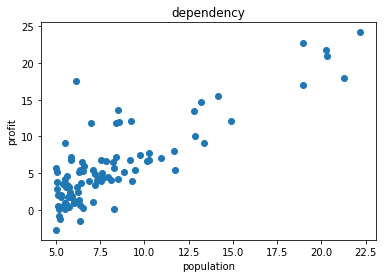

In [3]:
#Построить scatter plot зависимости прибыли от кол-ва людей в городе
plt.scatter(data['population'], data['profit'])
plt.xlabel('population')
plt.ylabel('profit')
plt.title('dependency')

In [4]:
# Найти матрицу Х и вектор у. Нормализировать данные. Добавить колонку единичек к матрице Х
arr = np.array(data['population'])
X_mean, X_std = np.mean(arr), np.std(arr)
X_normalized = np.reshape((arr - X_mean) / X_std, (len(arr),1))
ones = np.reshape(np.ones(len(arr)),(len(arr),1))
X_normalized = np.hstack((X_normalized,ones))
Y_vector = np.array(data['profit'])

In [5]:
# Написать mserror, linear_prediction в матричной форме
def mserror(y_vector, y_prediction):
    return np.mean((y_vector-y_prediction)**2)

def linear_prediction(weights, arguments):
    return np.dot(weights, arguments)

In [6]:
from time import time

def timed(fun):
    def timed_fun(*args, **kwargs):
        time_st = time()
        ret = fun(*args, **kwargs)
        return ret, (fun.__name__, round(time() - time_st, 2))
    return timed_fun
    
# Найти коэффициенты линейной модели
def gradient_step(X_matrix, y_vector, weights, train_inds, alpha=0.01):
    delta = (y_vector[train_inds] - linear_prediction(X_matrix[train_inds], weights))
    direction = np.dot(X_matrix[train_inds].transpose(), delta)
    return weights + alpha / X_matrix.shape[0] * direction

def find_directly(X_matrix, y_vector):
    X_square = np.dot(X_matrix.transpose(), X_matrix)
    vector = np.dot(X_matrix.transpose(), y_vector)
    return np.linalg.solve(X_square, vector)

@timed
def find_weights(X_matrix, y_vector, iter_num, mode):
    weights = np.ones(X_matrix.shape[1])
    for iteration in range(iter_num):
        train_inds = generate_inds(X_matrix.shape[0], mode=mode)
        weights = gradient_step(X_matrix, y_vector, weights, train_inds)
    last_weights = gradient_step(X_matrix, y_vector, weights, train_inds)
    return last_weights, weights - last_weights

def generate_inds(full_size, mode='full'):
    if mode == 'full':
        return np.ones(full_size, dtype=np.bool)
    if mode == 'batch':
        return np.random.randint(full_size, size=32)
    return np.random.randint(full_size, size=1)

In [7]:
true_coefs = find_directly(X_normalized, Y_vector)
print('direct calculations:', true_coefs)
msg = '{coef}: {spent_time} sec {iter} iterations for {fun_name}, last delta {delta}'
for mode in ['full', 'batch', 'single']:
    print('=' * 100)
    for iteration in [1000, 10000, 100000]:
        (weights, delta), (fun_name, spent_time) = find_weights(X_normalized, Y_vector, iteration, mode)
        print(msg.format(iter=iteration, delta=delta, coef=weights, spent_time=spent_time, fun_name=mode))


direct calculations: [4.59304113 5.83913505]
[4.59288757 5.83892823]: 0.04 sec 1000 iterations for full, last delta [-1.55116068e-06 -2.08911497e-06]
[4.59304113 5.83913505]: 0.28 sec 10000 iterations for full, last delta [0. 0.]
[4.59304113 5.83913505]: 2.23 sec 100000 iterations for full, last delta [0. 0.]
[4.48694923 5.65875971]: 0.04 sec 1000 iterations for batch, last delta [-0.00360795 -0.00338684]
[4.62340293 5.8569212 ]: 0.51 sec 10000 iterations for batch, last delta [-0.00088124 -0.00032696]
[4.58557442 5.82331214]: 3.93 sec 100000 iterations for batch, last delta [-1.45391953e-03 -9.97642684e-05]
[1.31113356 1.4615433 ]: 0.04 sec 1000 iterations for single, last delta [-6.20534820e-05 -3.58922337e-04]
[3.26192938 4.1057602 ]: 0.4 sec 10000 iterations for single, last delta [-6.09711614e-05  8.96539220e-05]
[4.55875175 5.7982396 ]: 3.67 sec 100000 iterations for single, last delta [-0.00024534  0.00052448]


Видно, что для фул батча 10000 достаточно 0.2 секунды, даже 0.02 для 1000 итераций дает хороший результат
Для остальных 4 секнды на 100000 итерациях не есть хорошо (просто выборка маленькая, всего 97 городов)

In [8]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression(fit_intercept=False, normalize=True).fit(X_normalized, Y_vector)
regression.coef_

array([4.59304113, 5.83913505])

The last method is very quick and gives exact value like the one I wrote by myself: find_directly()